# Periodic Data

If you can correctly guess the periodicity of your fluctuation, it seems that you can fit a linear model quite well by using a feature $x \rightarrow x,sin(x),cos(x)$.

This might be better than simply binning i.e. Monday, Tuesday, etc. because it understands the order of the days (including their repetition). 

I haven't had time to really look into this. When data is unrealistically dense, the periodic model is better. When the data is sparse, this doesn't seem to consistently be the case.


Also, in real life, a multiplicative model would probably be more appropriate.

Text(0.5, 1.0, 'weekly cycle')

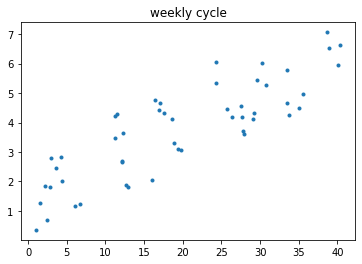

In [25]:
import numpy as np
import matplotlib.pyplot as plt

weekly_fluctuation = 1
daily_fluctuation = 0.5
trend = 0.125
noise = 0.75

N = 50
x = np.random.uniform(low=0,high=6*7,size=N)
y = np.abs(1+weekly_fluctuation*np.sin(2*np.pi*(x+np.random.randn()*7)/7) + daily_fluctuation*np.abs(np.sin(2*np.pi*x/2)) + noise*np.random.normal(size=N)) + trend*x

plt.plot(x,y,'.')
plt.title('weekly cycle')

Text(0.5, 1.0, 'weekly cycle')

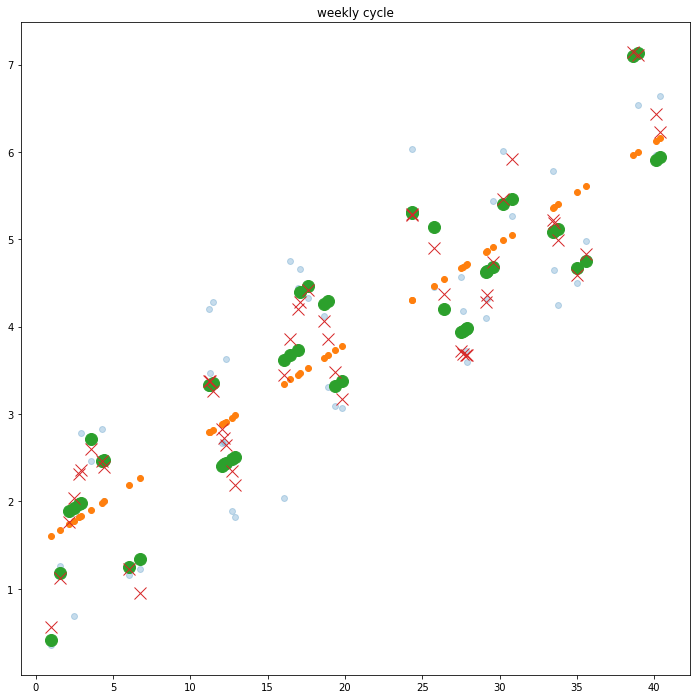

In [26]:
from sklearn.linear_model import LinearRegression


naive_reg = LinearRegression().fit(x.reshape(-1,1),y.reshape(-1,1))

day_dict = {day:7*[0] for day in range(7)}
for day in day_dict:
    day_dict[day][day%7]=1
    
binned_features = np.hstack([x.reshape(-1,1),np.array([day_dict[int(t)%7] for t in x])])
binned_reg = LinearRegression().fit(binned_features,y.reshape(-1,1))

periodic_features = np.vstack([x,np.sin(2*np.pi*x/7),np.cos(2*np.pi*x/7)]).T
periodic_reg = LinearRegression().fit(periodic_features,y.reshape(-1,1))

plt.figure(figsize=(12,12))
plt.plot(x,y,'o',alpha=0.25)
plt.plot(x,naive_reg.predict(x.reshape(-1,1)),'.',markersize=12)
plt.plot(x,binned_reg.predict(binned_features),'o',markersize=12)
plt.plot(x,periodic_reg.predict(periodic_features),'x',markersize=12)
plt.title('weekly cycle')

In [27]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y,naive_reg.predict(x.reshape(-1,1))))
print(mean_squared_error(y,binned_reg.predict(binned_features)))
print(mean_squared_error(y,periodic_reg.predict(periodic_features)))

0.7360188290682079
0.3493544443417246
0.2834955213861628
